# Homework - Week 4

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Importing dataset

In [243]:
PATH = "./AER_credit_card_data.csv"
data = pd.read_csv(PATH)

In [244]:
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [245]:
data.card = (data.card == 'yes').astype(int)
# data.card = data.card.map(dict(yes=1, no=0))

In [246]:
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparing validation framework

In [247]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

df_train = df_train.drop('card', axis=1)
df_val = df_val.drop('card', axis=1)
df_test = df_test.drop('card', axis=1)

In [248]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reports      791 non-null    int64  
 1   age          791 non-null    float64
 2   income       791 non-null    float64
 3   share        791 non-null    float64
 4   expenditure  791 non-null    float64
 5   owner        791 non-null    object 
 6   selfemp      791 non-null    object 
 7   dependents   791 non-null    int64  
 8   months       791 non-null    int64  
 9   majorcards   791 non-null    int64  
 10  active       791 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 68.1+ KB


## Question 1

Evaluating feature importance of numerical variables by calculating the AUC score against the target value.

In [249]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

In [250]:
list = []
for feature in numerical:
    auc = roc_auc_score(y_train, df_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
    else:
        auc = roc_auc_score(y_train, df_train[feature])
    list.append((feature, auc))

In [251]:
sorted(list, key=lambda x: x[1])

[('age', 0.5240020979407055),
 ('months', 0.5294217780967629),
 ('dependents', 0.5327757227773791),
 ('majorcards', 0.5343859842838476),
 ('income', 0.5908049467233478),
 ('active', 0.6043173411362006),
 ('reports', 0.7166629860689376),
 ('share', 0.989183643423692),
 ('expenditure', 0.991042345276873)]

The numerical value with the highest AUC from [reports, dependents, active, share] is **share**

## Question 2

In [252]:
features = ["reports", "age", "income", "share", "expenditure",
            "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [253]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

# y_pred = model.predict(X_val)
y_pred = model.predict_proba(X_val)[:, 1]

In [254]:
round(roc_auc_score(y_val, y_pred), 3)

0.995

## Question 3

Precision and recall of the model.

In [255]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t).astype(int)
    predict_negative = (y_pred < t).astype(int)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2*((precision*recall)/(precision+recall))
    
    scores.append((t, tp, fp, fn, tn, precision, recall, f1))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.00,211,53,0,0,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825,0.983133
97,0.97,203,0,8,53,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,1.000000,0.962085,0.980676
99,0.99,202,0,9,53,1.000000,0.957346,0.978208


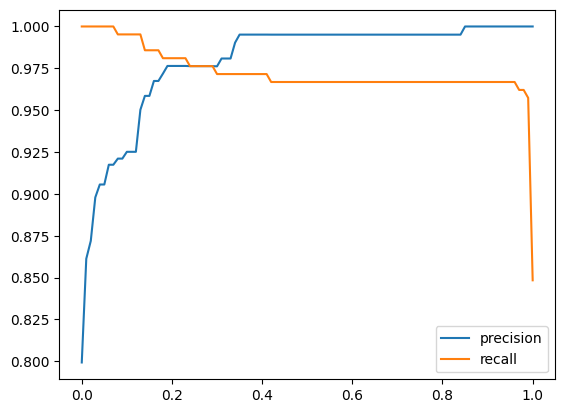

In [256]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

Precision and recall curves intersect at a threshold of around 0.3

## Question 4

Calculating F1 scores

In [257]:
max_f1 = df_scores['f1'].max()
df_scores.iloc[df_scores['f1'].idxmax(),:]

threshold      0.350000
tp           205.000000
fp             1.000000
fn             6.000000
tn            52.000000
precision      0.995146
recall         0.971564
f1             0.983213
Name: 35, dtype: float64

I get a maximal F1 at threshhold 0.35

## Question 5

In [263]:
df_full_train

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
710,0,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16
1258,1,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0
435,1,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13
987,0,0,25.58333,1.7500,0.000686,0.000000,no,no,0,108,0,0
1286,1,1,48.66667,6.0000,0.177017,885.085800,yes,no,3,114,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,0,38.33333,5.0000,0.057248,238.365000,yes,no,3,9,1,0
905,1,1,32.50000,10.0000,0.037040,308.250000,yes,no,3,35,1,4
1096,1,0,19.16667,1.9000,0.282962,448.023300,no,no,0,192,0,1
235,1,0,30.83333,3.0000,0.062629,156.572500,yes,no,2,72,1,8


In [273]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['card']
    y_val = df_val['card']
    
    dv, model = train(df_train, y_train, C=1.0)
    
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("Standard deviation of AUC scores: ", round(np.std(scores), 3))

Standard deviation of AUC scores:  0.003


## Question 6

In [274]:
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train['card']
        y_val = df_val['card']
    
        dv, model = train(df_train, y_train, C=C)
    
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    
    

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


C=1 and C=10 have the same mean and same standard deviation.
The smallest C is 1